## Saliency Maps

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
checkpoint = torch.load(checkpoint_path)
model = FinetuneClassifier(config)
model.load_state_dict(checkpoint['state_dict'])

/u/home/galc/mgca-modified/mgca-env/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


<All keys matched successfully>

Dataset size of split test: 1804


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1, 1])


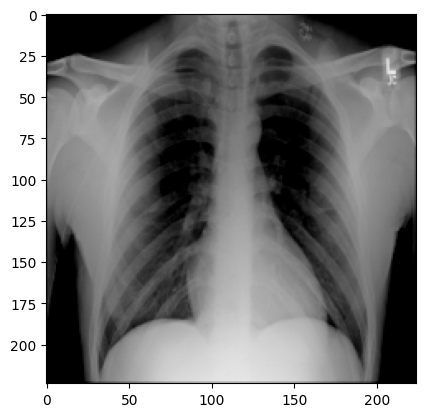

Label: tensor([0.])


In [7]:
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier
import numpy as np

config = load_config('../configs/rsna.yaml')

datamodule = DataModule(dataset=RSNAImageClsDataset, 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1.0,
                                batch_size=64, num_workers=16)

test_dataloader = datamodule.test_dataloader()

test_features, test_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
img = np.transpose(img, (1, 2, 0)) 
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('../annotations/rsna/test.csv')
df


,path,patientId,label,bbox
0,/u/home/galc/datasets/rsna/stage_2_train_image...,f2698fda-0477-435f-b297-f1b284a731aa,0,"[[0.0, 0.0, 0.0, 0.0]]"
1,/u/home/galc/datasets/rsna/stage_2_train_image...,b76dd4b8-7b51-4cb6-8fd7-0b7365ef3e1e,0,"[[0.0, 0.0, 0.0, 0.0]]"
2,/u/home/galc/datasets/rsna/stage_2_train_image...,5d8dbcf9-0d68-4aec-8638-b0a9f45d71d6,1,"[[605.0, 435.0, 808.0, 616.0]]"
3,/u/home/galc/datasets/rsna/stage_2_train_image...,39dc2e50-46a1-409e-ad59-98c33d300f2a,0,"[[0.0, 0.0, 0.0, 0.0]]"
4,/u/home/galc/datasets/rsna/stage_2_train_image...,b8a2e49e-c1fc-4a78-96dd-0ee4f835eaaa,1,"[[588.0, 75.0, 857.0, 783.0], [205.0, 75.0, 47..."
...,...,...,...,...
3998,/u/home/galc/datasets/rsna/stage_2_train_image...,418c026a-52a8-4b5f-a11b-5dec2fae20f5,1,"[[132.0, 236.0, 336.0, 570.0]]"
3999,/u/home/galc/datasets/rsna/stage_2_train_image...,4d5ca402-e14a-4b6c-86cd-d25512b31047,1,"[[604.0, 311.0, 796.0, 492.0]]"
4000,/u/home/galc/datasets/rsna/stage_2_train_image...,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,0,"[[0.0, 0.0, 0.0, 0.0]]"
4001,/u/home/galc/datasets/rsna/stage_2_train_image...,8489c930-19a8-4895-9211-4efd3d38ae58,1,"[[559.0, 202.0, 770.0, 381.0]]"


In [7]:
pneumonia = df[df["label"] == 1]
healthy = df[df["label"] == 0]

a_images = pneumonia.sample(5)["path"].tolist()
b_images = healthy.sample(5)["path"].tolist()

all_images = np.array([a_images, b_images]).flatten()

In [ ]:
from train_cls import load_config
from datasets.cls_dataset import RSNAImageTestDataset

config = load_config('../configs/rsna.yaml')

datamodule = DataModule(dataset=RSNAImageClsDataset(df), 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1.0,
                                batch_size=64, num_workers=16)

test_dataloader = datamodule.test_dataloader()

In [ ]:
import pydicom

def get_attention_map(path, get_mask=False):
    img = pydicom.dcmread(path).pixel_array
    loss, logits, preds, y, att_mat = model.shared_step(batch)
    outputs = model(**inputs, output_attentions=True)
    logits = outputs.logits
    att_mat = outputs["attentions"]

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")

    return img, result

In [15]:
cams = []
images = []

for x in all_images:
    tmp1, tmp2 = get_attention_map(x, True)
    images.append(tmp1)
    cams.append(tmp2) 

In [17]:
all_images

array(['/u/home/galc/datasets/rsna/stage_2_train_images/7798d157-4dbf-402c-8b93-d3b97cb29d64.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/76f71a93-8105-4c79-a010-0cfa86f0061a.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/bfbbedfe-0ab1-42bd-ac7f-e67b2a8e842a.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/e813b239-43c9-426d-b768-4a88d5e2c2e4.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/70e3331c-8717-4ff6-b2b5-0fefe6336bdc.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/e1ea50ee-d841-4819-b8ed-91b37efa1c72.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/9433b6d4-c05f-4a31-b7d6-0a002ca386bc.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/8da2a62e-732f-4646-a470-9a18af1204ad.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/6fdfe34b-f264-4bec-8669-b19786a1a6e8.dcm',
       '/u/home/galc/datasets/rsna/stage_2_train_images/0a41d5c4-83b0-43e4-b98f-be69dcdd4636.dcm'],
      dty

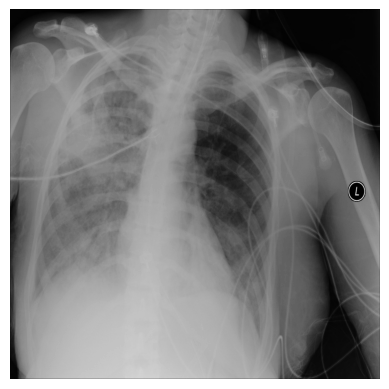

In [9]:
import pydicom
import matplotlib.pyplot as plt

images = [pydicom.dcmread(path).pixel_array for path in all_images]

plt.imshow(images[0], cmap="gray")
plt.axis('off')
plt.show()

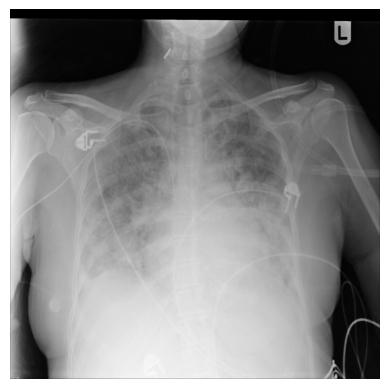

In [12]:
plt.imshow(images[4], cmap="gray")
plt.axis('off')
plt.show()

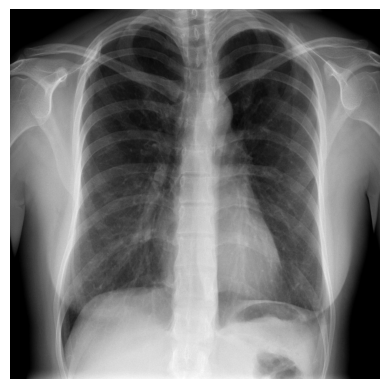

In [13]:
plt.imshow(images[9], cmap="gray")
plt.axis('off')
plt.show()

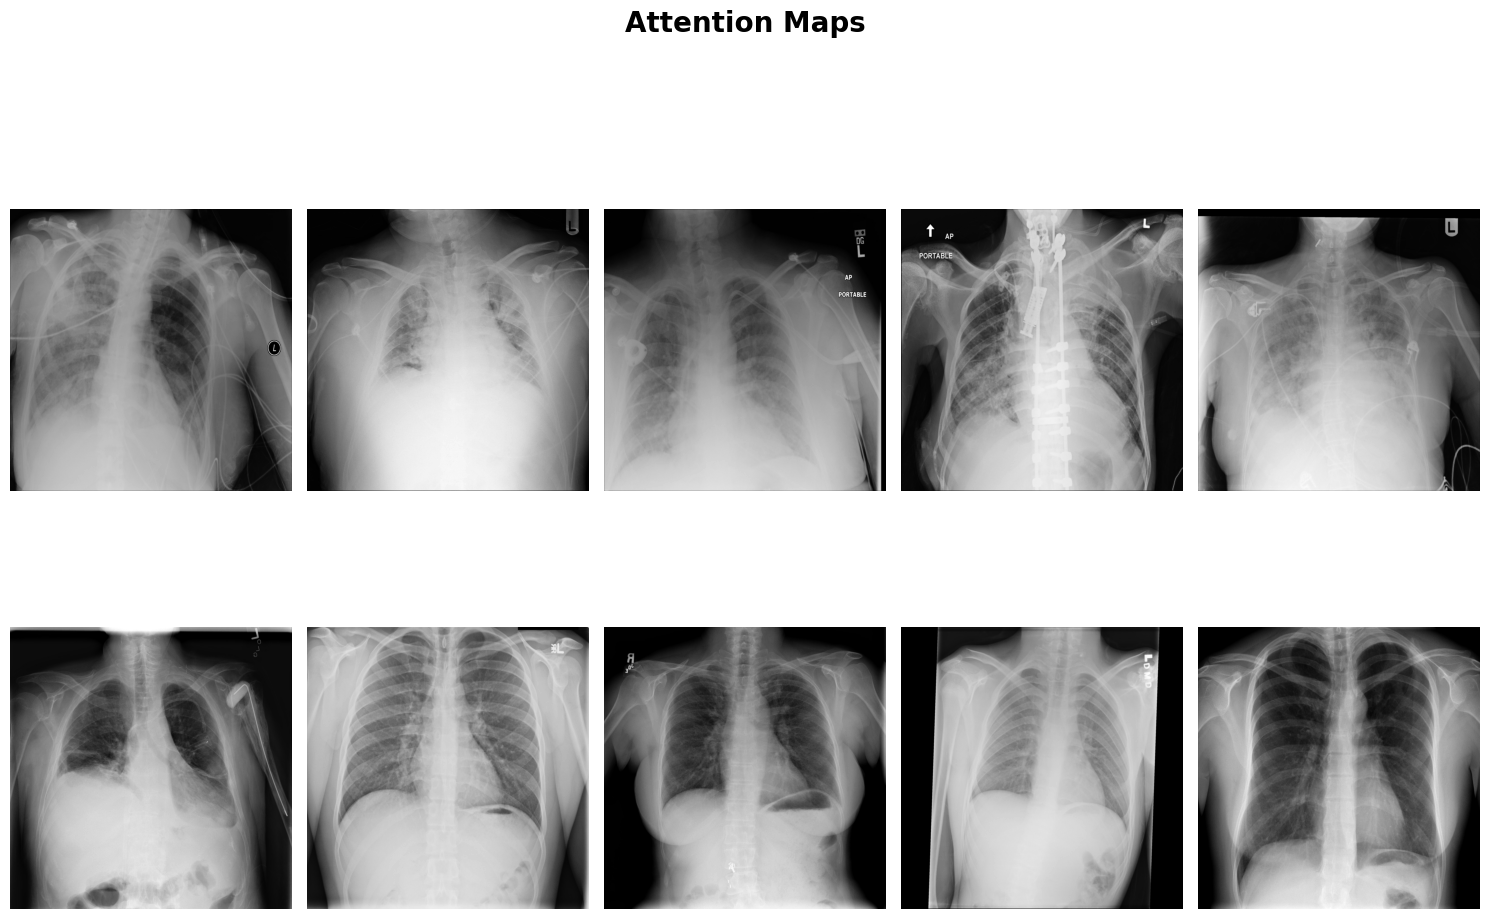

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(15,10))

for x in range(2):
    for y in range(5):
        ax[x][y].imshow(images[x*5+y], cmap="gray")
        # ax[x][y].imshow(cams[x*5+y], alpha=0.7)
        ax[x][y].axis('off')

        
plt.tight_layout()
plt.suptitle('Attention Maps',fontweight ="bold", size=20, y=1.05)
plt.show()

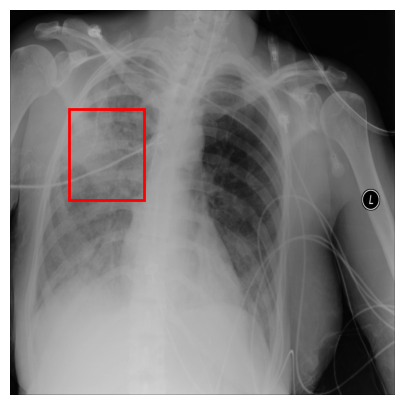

In [1]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_dicom_with_bboxes(dicom_path, bboxes):
    """
    Plots a DICOM image with overlaid bounding boxes.
    
    :param dicom_path: Path to the DICOM file.
    :param bboxes: List of bounding boxes, where each box is [x_min, y_min, x_max, y_max].
    """
    # Load the DICOM image
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    
    # Overlay the bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    # Show the plot
    plt.axis('off')
    plt.show()

# Example usage
dicom_path = "/u/home/galc/datasets/rsna/stage_2_train_images/7798d157-4dbf-402c-8b93-d3b97cb29d64.dcm"
bboxes = [[156.0, 263.0, 357.0, 506.0]]  # Replace with your bounding boxes
plot_dicom_with_bboxes(dicom_path, bboxes)

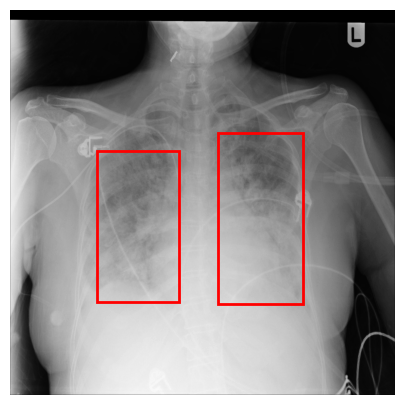

In [3]:
dicom_path = "//u/home/galc/datasets/rsna/stage_2_train_images/70e3331c-8717-4ff6-b2b5-0fefe6336bdc.dcm"
bboxes = [[553.0, 326.0, 780.0, 782.0], [231.0, 374.0, 448.0, 775.0]]  # Replace with your bounding boxes
plot_dicom_with_bboxes(dicom_path, bboxes)

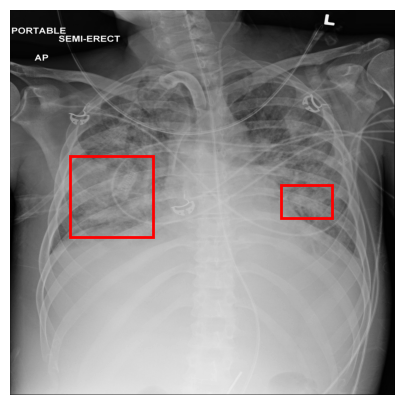

In [3]:
dicom_path = "/u/home/galc/datasets/rsna/stage_2_train_images/dc2a32fa-d49c-4c49-bcdc-3ae6c394fbc9.dcm"
bboxes = [[158.0, 389.0, 381.0, 602.0], [720.0, 466.0, 855.0, 554.0]]  # Replace with your bounding boxes
plot_dicom_with_bboxes(dicom_path, bboxes)

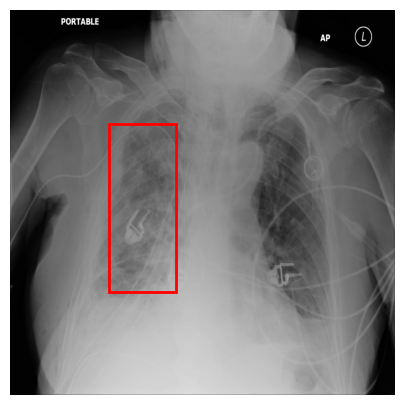

In [3]:
dicom_path = "/u/home/galc/datasets/rsna/stage_2_train_images/7307c83f-63e1-46e1-9400-8d1eac241510.dcm"
bboxes = [[262.0, 302.0, 440.0, 749.0]]  # Replace with your bounding boxes
plot_dicom_with_bboxes(dicom_path, bboxes)

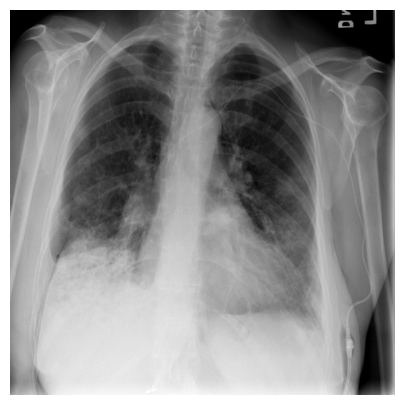

In [4]:
dicom_path = "/u/home/galc/datasets/rsna/stage_2_train_images/fcb12207-113f-4c5a-9b23-0bbf5f280a59.dcm"
bboxes = [[0, 0, 0, 0]]  # Replace with your bounding boxes
plot_dicom_with_bboxes(dicom_path, bboxes)

## Confusion Matrix

In [19]:
import json
import pandas as pd

validation_losses = []
# Load logged losses
# with open("test_losses_convirt.json", "r") as f:
with open("../test_losses/test_losses_medclip.json", "r") as f:
    for line in f:
        validation_losses.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(validation_losses)

df

,batch_idx,loss,preds,labels
0,0,0.072491,0,0.0
1,1,0.681580,0,0.0
2,2,1.616024,0,1.0
3,3,0.008639,0,0.0
4,4,0.266495,1,1.0
...,...,...,...,...
3998,3998,1.031445,0,1.0
3999,3999,0.536834,1,1.0
4000,4000,0.066153,0,0.0
4001,4001,2.405794,0,1.0


In [20]:
df["labels"].value_counts()

0.0    3081
1.0     922
Name: labels, dtype: int64

In [21]:
df['preds'].value_counts()

0    3247
1     756
Name: preds, dtype: int64

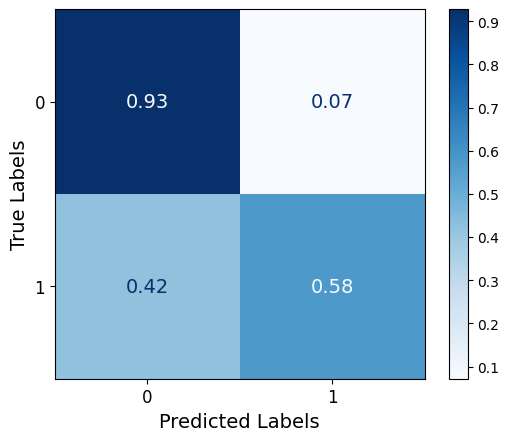

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = metrics.confusion_matrix(df['labels'], df['preds'])

# Normalize the confusion matrix by the total number of samples
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create the display for the confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cmn, display_labels=[0, 1])

# Plot with a blue color map
cm_display.plot(cmap='Blues', values_format='.2f')
# plt.title('MedCLIP - classification with RSNA')
cm_display.ax_.set_xlabel('Predicted Labels', fontsize=14)
cm_display.ax_.set_ylabel('True Labels', fontsize=14)
for text in cm_display.ax_.texts:  # Access the texts in the plot
    text.set_fontsize(14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("cm_medclip.pdf", format="pdf", dpi=300)
plt.show()

In [16]:
sorted_loss_df = df.sort_values(by="loss", ascending=False)
sorted_loss_df

,batch_idx,loss,preds,labels
3728,3728,4.894003,0,1.0
153,153,4.713731,0,1.0
1217,1217,4.707642,0,1.0
1632,1632,4.428976,0,1.0
462,462,4.357889,0,1.0
...,...,...,...,...
3339,3339,0.002755,0,0.0
3150,3150,0.002608,0,0.0
3732,3732,0.002580,0,0.0
3140,3140,0.002540,0,0.0


## CheXpert embeddings

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

# checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt' # CONVIRT
checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_21_19_05_29/epoch=18-step=55137.ckpt' #MEDCLIP
checkpoint = torch.load(checkpoint_path)
finetuned_convirt = FinetuneClassifier(config)
finetuned_convirt.load_state_dict(checkpoint['state_dict'])

/u/home/galc/mgca-modified/mgca-env/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook


<All keys matched successfully>

In [2]:
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms

datamodule = DataModule(dataset=ChexPertImageClsDataset, 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1,
                                batch_size=64, num_workers=16)

In [3]:
import torch
from methods.cls_model import FinetuneClassifier

def extract_embeddings(model, dataloader):
    model.eval()  # Ensure the model is in evaluation mode
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            feats, labels = model.shared_step(batch, return_embeddings=True)
            all_feats.append(feats.cpu())  # Move to CPU
            all_labels.append(labels.cpu())

    # Concatenate all features and labels
    all_feats = torch.cat(all_feats)
    all_labels = torch.cat(all_labels)
    return all_feats, all_labels

In [4]:
# Assuming you have a trained model and a Trainer instance
val_dataloader = datamodule.val_dataloader()  # Validation dataloader
val_feats, val_labels = extract_embeddings(finetuned_convirt, val_dataloader)
print(val_feats.shape)  # (num_samples, embedding_dim)
print(val_labels.shape) 

Dataset size of split valid: 4234
torch.Size([4224, 2048])
torch.Size([4224, 5])


In [5]:
# Assuming you have a trained model and a Trainer instance
test_dataloader = datamodule.test_dataloader()  # Test dataloader
test_feats, test_labels = extract_embeddings(finetuned_convirt, test_dataloader)
print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape) 

Dataset size of split test: 202
torch.Size([202, 2048])
torch.Size([202, 5])


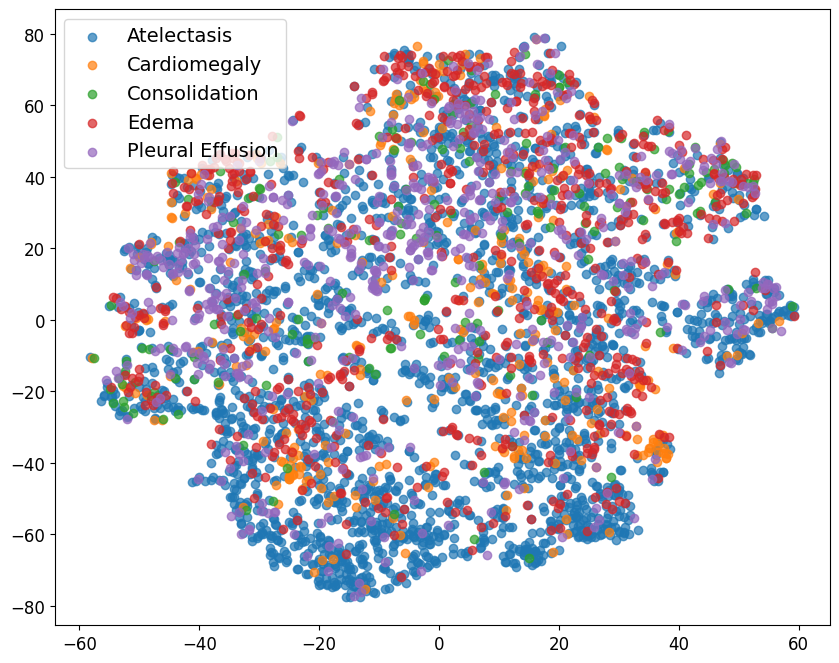

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = val_feats.numpy()
labels_np = val_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

import pickle
with open("CheXpert_embeddings_MedCLIP.pkl", 'wb') as f:
    pickle.dump((embeddings_np, labels_np), f)

# Apply t-SNE to reduce dimensionality
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# embeddings_2d = tsne.fit_transform(embeddings_np)

# Visualize
def plot_embeddings_tsne(embeddings, labels, class_names):
    # Apply t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.title("t-SNE Visualization of Image Embeddings", fontsize=16)
    plt.savefig("embeddings_medclip_balanced.pdf", format="pdf", dpi=300)
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings_tsne(embeddings_np, labels_np, class_names)

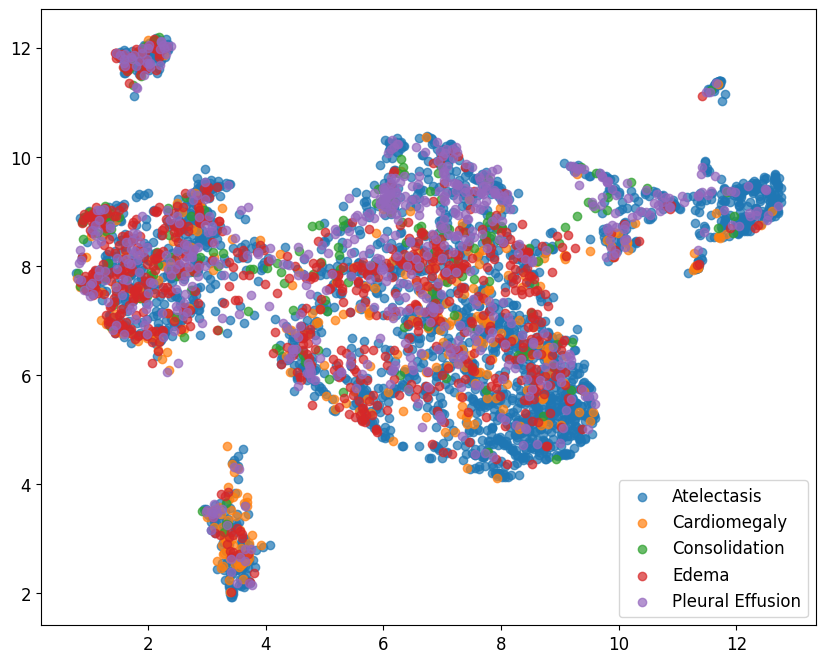

In [8]:
import umap

def plot_embeddings_umap(embeddings, labels, class_names, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    # Perform UMAP dimensionality reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)
    
    # Plot the reduced embeddings
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    
    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.title("UMAP Visualization of Image Embeddings", fontsize=16)
    plt.savefig("embeddings_umap_visualization.pdf", format="pdf", dpi=300)
    plt.show()
    
plot_embeddings_umap(embeddings_np, labels_np, class_names)

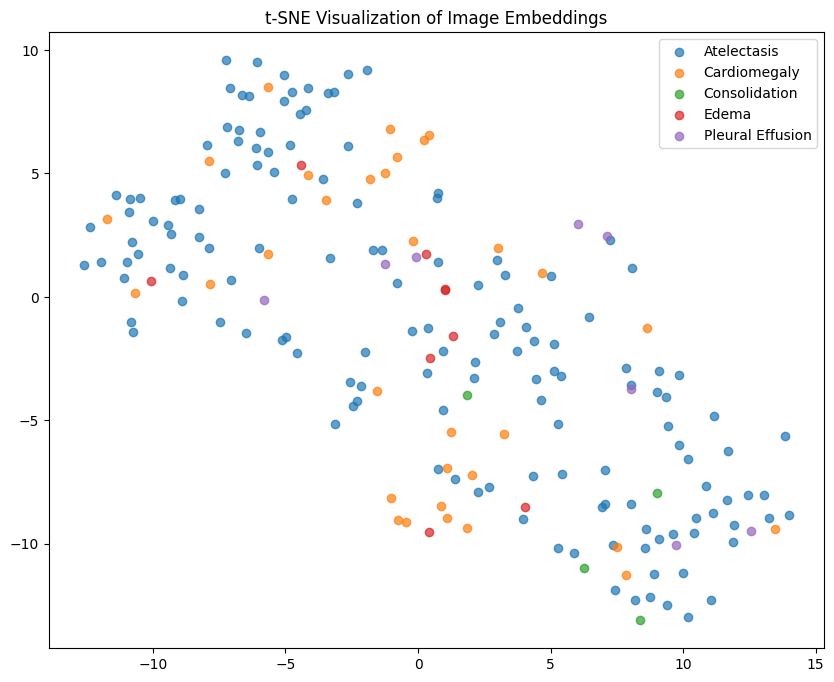

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = test_feats.numpy()
labels_np = test_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Visualize
def plot_embeddings(embeddings_2d, labels, class_names):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings(embeddings_2d, labels_np, class_names)

In [9]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

# checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
# checkpoint = torch.load(checkpoint_path)
finetuned_imagenet = FinetuneClassifier(config)
# finetuned_convirt.load_state_dict(checkpoint['state_dict'])

In [10]:
# Assuming you have a trained model and a Trainer instance
val_dataloader = datamodule.val_dataloader()  # Validation dataloader
val_feats, val_labels = extract_embeddings(finetuned_imagenet, val_dataloader)
print(val_feats.shape)  # (num_samples, embedding_dim)
print(val_labels.shape) 

Dataset size of split valid: 4234
torch.Size([4224, 768])
torch.Size([4224, 5])


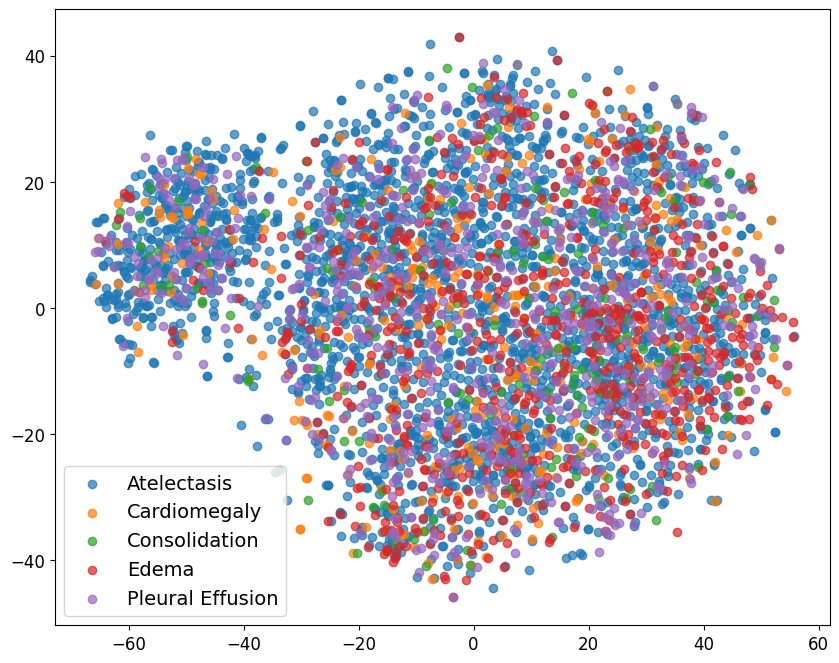

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = val_feats.numpy()
labels_np = val_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

# Visualize
def plot_embeddings_tsne(embeddings, labels, class_names):
    # Apply t-SNE to reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    
    plt.legend(fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.title("t-SNE Visualization of Image Embeddings", fontsize=16)
    plt.savefig("embeddings_imagenet_tsne.pdf", format="pdf", dpi=300)
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings_tsne(embeddings_np, labels_np, class_names)

## RSNA (binary) Embeddings

In [ ]:
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier
from datasets.cls_dataset import RSNAImageClsDataset  # Using RSNA dataset now
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#plot for binary RSNA

def plot_embeddings(embeddings_2d, labels, class_names, title, path_to_save):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        # Flatten the labels to ensure correct indexing
        idx = labels.ravel() == class_idx  # Make sure labels are 1D
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title(f"{title} - t-SNE Visualization of Image Embeddings")
    #save as high res image
    plt.savefig(path_to_save, format="pdf", dpi=300)
    plt.show() 

In [ ]:
config = load_config('../configs/rsna.yaml')
finetuned_rsna = FinetuneClassifier(config) #init model

method = "medclip" #medclip or convirt

#adapt checkpoint path..
checkpoint_path_medclip = '/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/data/ckpts/FinetuneCLS/rsna/2025_01_17_14_27_25/epoch=27-step=8147.ckpt'
checkpoint_path_convirt = '/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/data/ckpts/FinetuneCLS/rsna/2025_01_17_14_35_16/epoch=12-step=3782.ckpt'


if method == "medclip":
    checkpoint_path = checkpoint_path_medclip
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    state_dict = checkpoint['state_dict']
    # Remove the keys corresponding to the extra layers 
    for key in list(state_dict.keys()):
        if "classification_head.block_forward.3" in key or "classification_head.block_forward.6" in key:
            state_dict.pop(key)

    #finetuned_rsna.load_state_dict(state_dict)
    finetuned_rsna.load_state_dict(state_dict, strict=False) #try strict= False if not working

elif method == "convirt":
    checkpoint_path = checkpoint_path_convirt
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    state_dict = checkpoint['state_dict']

    for key in list(state_dict.keys()):
        if 'classification_head' in key:
            del state_dict[key]

    # Load the state_dict with the remaining weights
    finetuned_rsna.load_state_dict(state_dict, strict=False)

In [ ]:
# RSNA DataModule (binary classification task)
datamodule = DataModule(dataset=RSNAImageClsDataset, 
                        config=config, collate_fn=None,
                        transforms=DataTransforms, data_pct=1,
                        batch_size=64, num_workers=16)

In [ ]:
test_dataloader = datamodule.test_dataloader() 
test_feats, test_labels = extract_embeddings(finetuned_rsna, test_dataloader) # extract embeddings

print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape)

In [ ]:
embeddings_np = test_feats.numpy()
labels_np = test_labels.numpy()

# Normalize embeddings 
scaler = StandardScaler()
embeddings_np = scaler.fit_transform(embeddings_np)

tsne = TSNE(n_components=2, perplexity=30, random_state=42) #apply tsne
embeddings_2d = tsne.fit_transform(embeddings_np)

In [ ]:
class_names = ["No Finding", "Pneumonia"]  
plot_embeddings(embeddings_2d, labels_np, class_names, method, "rsna_embeddings_{method}_balanced.pdf")

## Compute Cluster scores

In [ ]:
from sklearn.metrics import silhouette_score

#Measures how similar each point is to its own cluster compared to other clusters
#Values range from -1 (bad clustering) to 1 (perfect clustering)
#Recommended if: You have at least two distinct clusters and want a simple metric for cohesion and separation.

silhouette_avg = silhouette_score(embeddings_2d, labels_np) 
print(f"Silhouette Score: {silhouette_avg}")

In [ ]:
from sklearn.metrics import calinski_harabasz_score

#measures the ratio of between-cluster dispersion to within-cluster dispersion
#value: the higher the better
#Recommended if: You want a score that rewards well-separated clusters with low within-cluster variance

ch_index = calinski_harabasz_score(embeddings_2d, labels_np)
print(f"Calinski-Harabasz Index: {ch_index}")